# Отток клиентов банка

В работе используется датасет с Kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers, в котором приведены данные клиентов банка и факт их оттока. Будем строить наиболее качественную модель, которая поможет выявить клиентов, которые могут уйти. Ключевой метрикой качества будет accuracy, результат будет удобно сравнить с другими участниками соревнований на площадке kaggle. Так, у лучших работ, которые базируются на работе нейросетей, accuracy превышает 90% по данному кейсу. Попробуем получить близкий к 90% результат при помощи более быстрых и простых алгоритмов.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

## Изучение и обработка данных:

In [2]:
df = pd.read_csv('D:\Churn_Modelling.csv')

In [3]:
df_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info=df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                             rename(index={0:'null values (%)'}))
display(df_info)
print('Размер df:', df.shape)
display(df[:5])

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
column type,int64,int64,object,int64,object,object,int64,int64,float64,int64,int64,int64,float64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0


Размер df: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Датасет содержит следующие признаки:

<br><b> Признаки </b>
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

<br><b> Целевой признак </b>
* Exited — факт ухода клиента

В датасете 10000 строк и 14 признаков. Некоторые типы данных стоит изменить. Не все признаки будут полезны для построения модели. Например, RowNumber, CustomerId и Surname точно ничем не помогут, их лучше удалить.

In [4]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1)

In [5]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


При помощи метода describe получил больше информации о данных, здесь из необычного могу отметить высокий разброс значений в balance, при этом 25% квантиль = 0, т.е. очень много нулевых счетов, далее построю графики чтобы лучше увидеть распределение значений. В estimatedsalary среднее почти равно медиане, хотя в реальности в области зарплат среднее всегда заметно выше из-за особенности распределения этого показателя (распределение Пуассона), возможно датасет заранее обработан на выбросы. По среднему exited (целевой признак) видно, что отвалились 20% клиентов, соответственно дисбаланс классов 80/20. Также было бы интересно посмотреть на целевой признак у нулевых счетов:

In [6]:
df.query('Balance == 0')['Exited'].mean()

0.13823610727121924

In [7]:
df.query('Balance > 0')['Exited'].mean()

0.2407958640137866

С нулевыми счетами отвалилось лишь 13.8% клиентов, при том что с ненулевыми - 24%. Скорее всего это можно объяснить тем, что клиенты с нулевыми считами менее активны в целом, т.е. им более безразлично являются они клиентами банка или нет. Влияние признака довольно большое в нуле, возможно стоит сделать дополнительный признак булева типа (нулевой/ненулевой счет), который может сработать на улучшение модели.

In [8]:
df['IsNotNullBalance'] = df['Balance'][df['Balance'] > 0]
df['IsNotNullBalance'] = df['IsNotNullBalance'].fillna(0)
df['IsNotNullBalance'][df['IsNotNullBalance'] > 0] = 1
df['IsNotNullBalance'] = df['IsNotNullBalance'].astype('bool')

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsNotNullBalance
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,False
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,True
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,True
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,False
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,True


Изменим типы данных на более оптимальные/подходящие с точки зрения требования к памяти и смысла:

In [10]:
df['CreditScore'] = df['CreditScore'].astype('int32')
df['Age'] = df['Age'].astype('int32')
df['NumOfProducts'] = df['NumOfProducts'].astype('int32')
df['HasCrCard'] = df['HasCrCard'].astype('int8')
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
df['Exited'] = df['Exited'].astype('int8')
df['Tenure'] = df['Tenure'].astype('int32')

Также, имеет смысл заменить значения строкового поля gender на булево. Пусть male = 1, female = 0.

In [11]:
df['Gender'] = df['Gender'].replace('Male', 1)
df['Gender'] = df['Gender'].replace('Female', 0)
df['Gender'] = df['Gender'].astype('int8')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CreditScore       10000 non-null  int32  
 1   Geography         10000 non-null  object 
 2   Gender            10000 non-null  int8   
 3   Age               10000 non-null  int32  
 4   Tenure            10000 non-null  int32  
 5   Balance           10000 non-null  float64
 6   NumOfProducts     10000 non-null  int32  
 7   HasCrCard         10000 non-null  int8   
 8   IsActiveMember    10000 non-null  bool   
 9   EstimatedSalary   10000 non-null  float64
 10  Exited            10000 non-null  int8   
 11  IsNotNullBalance  10000 non-null  bool   
dtypes: bool(2), float64(2), int32(4), int8(3), object(1)
memory usage: 439.6+ KB


## EDA

Сначала разделим датасет на выборки, потом затем приступим к EDA и обучению моделей:

In [13]:
random_state = 42 # глобальный параметр псевдослучайности

In [14]:
train, test = train_test_split(df, test_size=0.25, random_state=random_state, stratify = df['Exited'])

In [15]:
display(len(train)/len(df))
display(len(test)/len(df))

0.75

0.25

25% выборки отделены в качестве тестовой со стратификацией по целевому признаку.

In [16]:
train.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited
count,7500.000000,7500.000000,7500.00000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,650.507733,0.550667,38.98000,5.022800,76328.197195,1.532267,0.707200,99540.472065,0.203733
std,96.637724,0.497459,10.55188,2.893613,62385.961630,0.581897,0.455078,57295.127395,0.402800
min,350.000000,0.000000,18.00000,0.000000,0.000000,1.000000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,32.00000,3.000000,0.000000,1.000000,0.000000,50417.950000,0.000000
50%,652.000000,1.000000,37.00000,5.000000,96943.320000,1.000000,1.000000,98940.675000,0.000000
75%,717.000000,1.000000,44.00000,8.000000,127785.447500,2.000000,1.000000,148428.572500,0.000000
max,850.000000,1.000000,92.00000,10.000000,222267.630000,4.000000,1.000000,199992.480000,1.000000


Данные разделены корректно, ключевые показатели практически не изменились.

Посмотрим на распределения количественных признаков:

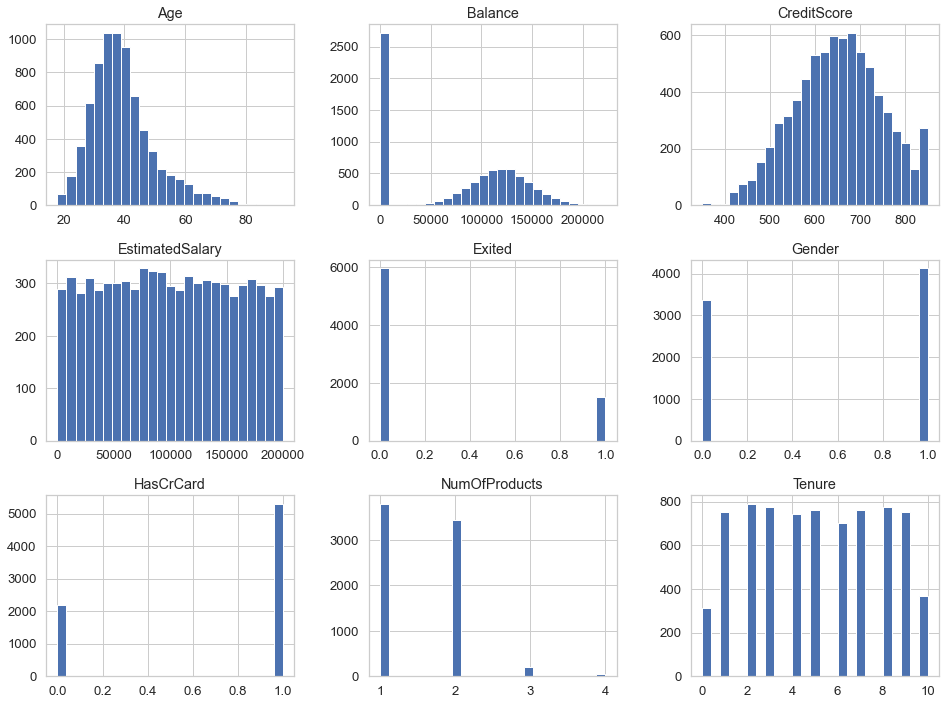

In [17]:
sns.set(style="whitegrid", font_scale=1.2)
train[train.describe().columns.to_list()].hist(figsize=(16, 12), bins=25);

* Возраст клиентов банка распределен близко к нормальному, с небольшим хвостом. Варьируется от 18 до 92 лет.
* В балансе есть выброс в нуле, который уже был отмечен. За исключением нуля признак распределен нормально. 
* Также был создан дополнительный признак для нулевых счетов. 
* Кредитный рейтинг немного скошен вправо. Количество клиентов возрастает до уровня ~640, затем начинает убывать вплоть до последнего бара,где наблюдается небольшой всплеск числа клиентов с максимальным рейтингом.
* По оцениваемой зарплате мы имеем примерно одинаковое количество клиентов в каждом баре, отсюда равенство среднего и медианы, это нетипично для такого показателя.
* Обычно клиенты пользуются 1 или 2 продуктами банка, намного реже используют 3 или 4.
* Количество недвижимости у клиентов банка варьируется от 0 до 10, при этом показатели 0 и 10 встречаются заметно реже, чем остальные, которые встречаются примерно одинаково часто.

Для того чтобы понять как количественные признаки влияют на уход клиента построим таблицу, в которой будут представлены средние значения признаков в двух группах - тех, кто ушел (Exited=1) и тех, кто остался (Exited=0).

In [18]:
def compare_features (features, target_name):
    remaining = features[features[target_name] == 0].mean().to_frame().rename(columns={0:'not exited'})
    departed = features[features[target_name] == 1].mean().to_frame().rename(columns={0:'exited'})
    compare = remaining.join(departed, how = 'outer')
    compare['diff_pct'] = ((compare['exited'] - compare['not exited']) / compare['exited']* 100).round(2)
    return compare

In [19]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Exited']

In [20]:
diff_table = compare_features(train[numeric_features], 'Exited')
diff_table

,not exited,exited,diff_pct
CreditScore,652.159578,644.051702,-1.26
Age,37.523778,44.671466,16.00
Tenure,5.016075,5.049084,0.65
Balance,72586.958505,90950.368305,20.19
NumOfProducts,1.546383,1.477094,-4.69
EstimatedSalary,98868.429612,102167.067310,3.23
Exited,0.000000,1.000000,100.00


В таблице представлены средние показатели по оставшимся клиентам (not exited) и ушедшим (exited). В столбце diff_pct <b> отражена процентная разница: на сколько меньше среднее значение показателя среди ушедших клиентов чем у оставшихся.

Добавим визуализацию и сделаем выводы:

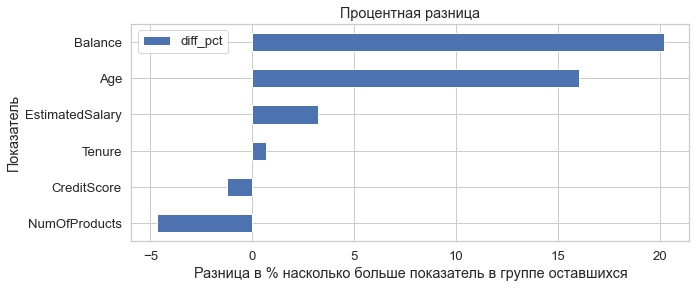

In [21]:
diff_table[['diff_pct']].drop(['Exited']).sort_values(by = 'diff_pct').plot(kind = 'barh', figsize = (10, 4), grid = True)
plt.xlabel('Разница в % насколько больше показатель в группе оставшихся')
plt.ylabel('Показатель')
plt.title('Процентная разница');

* Самая большая разница в пользу ушедших клиентов в признаке Balance: средний баланс на счёте у ушедшего клиента превышает на 19.5% баланс на счёте клиента, который остался. Но тут нужно помнить, что среди оставшихся клиентов больше количество неактивных, с нулевыми счетами. Ниже посчитаем разницу между средними с устранением нулевых счетов.
* Средний возраст ушедшего клиента почти 45 лет, в то время как оставшегося - 37 лет.
* Остальные признаки находятся примерно на одном уровне, не факт, что между ними есть статистически значимая разница.

In [22]:
train.query('Exited == 1 and Balance > 0')['Balance'].agg(['mean', 'count'])

mean     120740.367307
count      1151.000000
Name: Balance, dtype: float64

In [23]:
train.query('Exited == 0 and Balance > 0')['Balance'].agg(['mean', 'count'])

mean     119418.544405
count      3630.000000
Name: Balance, dtype: float64

* Если убрать нулевые счета, то средние балансы в двух группах окажутся на одном уровне.

Подготовим данные для визуализации <b>категориальных признаков:

In [24]:
gender_share = {
    'Факт ухода' : ['Ушел в отток', 'Остался'],
    
    'Доля мужчин' : [train[train['Exited'] == 1]['Gender'].mean(),
                      train[train['Exited'] == 0]['Gender'].mean()],
    
    'Доля женщин' : [1 - train[train['Exited'] == 1]['Gender'].mean(),
                      1 - train[train['Exited'] == 0]['Gender'].mean()]
                           }
gender_share = pd.DataFrame(data=gender_share)

hascrcard_share = {
    'Факт ухода' : ['Ушел в отток', 'Остался'],
    
    'Есть кредитная карта' : [train[train['Exited'] == 1]['HasCrCard'].mean(),
                      train[train['Exited'] == 0]['HasCrCard'].mean()],
    
    'Нет кредитной карты' : [1 - train[train['Exited'] == 1]['HasCrCard'].mean(),
                      1 - train[train['Exited'] == 0]['HasCrCard'].mean()]
                           }
hascrcard_share = pd.DataFrame(data=hascrcard_share)

isactivemember_share = {
    'Факт ухода' : ['Ушел в отток', 'Остался'],
    
    'Является активным клиентом' : [train[train['Exited'] == 1]['IsActiveMember'].mean(),
                      train[train['Exited'] == 0]['IsActiveMember'].mean()],
    
    'Не является активным клиентом' : [1 - train[train['Exited'] == 1]['IsActiveMember'].mean(),
                      1 - train[train['Exited'] == 0]['IsActiveMember'].mean()]
                           }
isactivemember_share = pd.DataFrame(data=isactivemember_share)

Выведем таблицы с рассчитанными данными и визуализируем их:

In [25]:
gender_share

,Факт ухода,Доля мужчин,Доля женщин
0,Ушел в отток,0.445026,0.554974
1,Остался,0.577696,0.422304


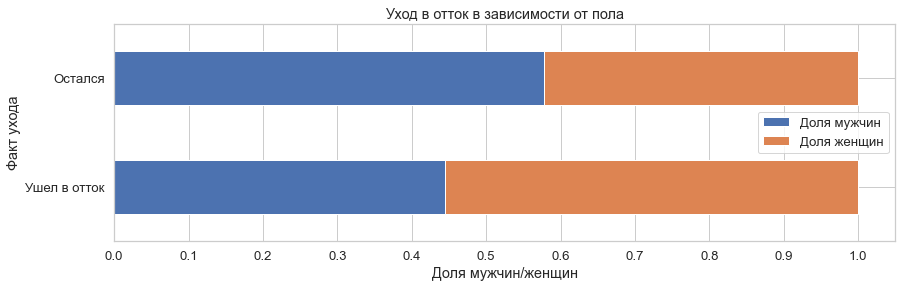

In [26]:
gender_share.plot(x = 'Факт ухода', kind = 'barh', figsize = (14, 4), grid = True, stacked = True, legend = True)
plt.title('Уход в отток в зависимости от пола')
plt.xlabel('Доля мужчин/женщин')
plt.xticks(np.arange(0, 1.1, 0.1));

* Женщины чаще уходили в отток, среди оставшихся доля женщин 42.9%, в то время как среди ушедших заметно больше - 55.6%

In [27]:
hascrcard_share

,Факт ухода,Есть кредитная карта,Нет кредитной карты
0,Ушел в отток,0.695681,0.304319
1,Остался,0.710147,0.289853


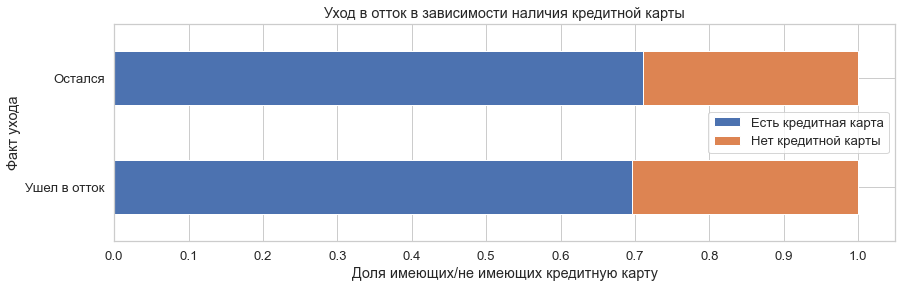

In [28]:
hascrcard_share.plot(x = 'Факт ухода', kind = 'barh', figsize = (14, 4), grid = True, stacked = True, legend = True)
plt.title('Уход в отток в зависимости наличия кредитной карты')
plt.xlabel('Доля имеющих/не имеющих кредитную карту')
plt.xticks(np.arange(0, 1.1, 0.1));

* Наличие кредитной карты практически не влияет на факт ухода клиентов банка

In [29]:
isactivemember_share

,Факт ухода,Является активным клиентом,Не является активным клиентом
0,Ушел в отток,0.366492,0.633508
1,Остался,0.555090,0.444910


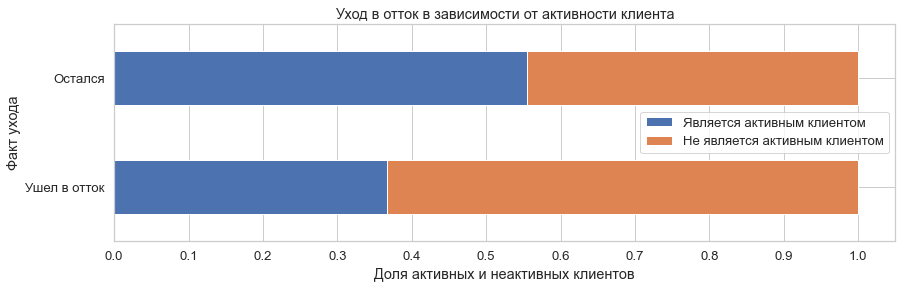

In [30]:
isactivemember_share.plot(x = 'Факт ухода', kind = 'barh', figsize = (14, 4), grid = True, stacked = True, legend = True)
plt.title('Уход в отток в зависимости от активности клиента')
plt.xlabel('Доля активных и неактивных клиентов')
plt.xticks(np.arange(0, 1.1, 0.1));

* В отток чаще выходят клиенты, не являющиеся активными. К сожалению, отсутствует пояснение по какому принципу банк относит клиента к активному

Посмотрим в каких странах (признак Geography) клиенты склонны к оттоку.

In [31]:
geography_exited = train[train['Exited'] == 1]['Geography'].value_counts().to_frame().reset_index()\
.rename(columns={'Geography':'count', 'index' : 'geo'})
geography_exited['share_exited'] = geography_exited['count'] / geography_exited['count'].sum()
geography_exited = geography_exited.drop('count', axis=1)

geography_not_exited = train[train['Exited'] == 0]['Geography'].value_counts().to_frame().reset_index()\
.rename(columns={'Geography':'count', 'index' : 'geo'})
geography_not_exited['share_not_exited'] = geography_not_exited['count'] / geography_not_exited['count'].sum()
geography_not_exited = geography_not_exited.drop('count', axis=1)

In [32]:
geo_compare = geography_exited.merge(geography_not_exited, how = 'outer', on='geo')

In [33]:
geo_compare['diff_pct'] = geo_compare['share_exited'] - geo_compare['share_not_exited']

In [34]:
geo_compare

,geo,share_exited,share_not_exited,diff_pct
0,Germany,0.402487,0.210315,0.192172
1,France,0.392016,0.525787,-0.133771
2,Spain,0.205497,0.263898,-0.058401


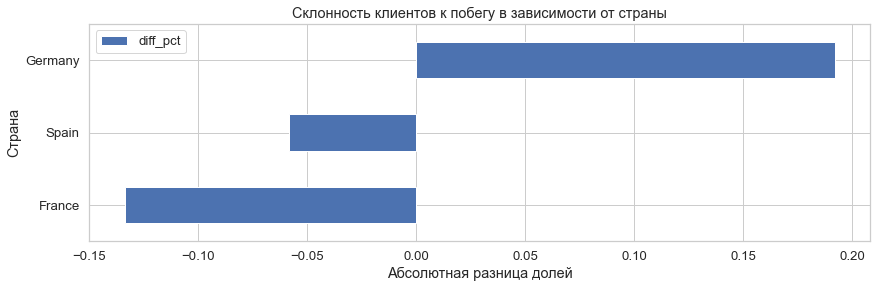

In [35]:
geo_compare[['geo','diff_pct']].sort_values(by = 'diff_pct').plot(x='geo', kind = 'barh', figsize = (14, 4), grid = True)
plt.xlabel('Абсолютная разница долей')
plt.ylabel('Страна')
plt.title('Склонность клиентов к побегу в зависимости от страны');

* Клиенты из Германии наиболее склоны попадать в отток: в группе оставшихся 21% клиентов из Германии, в группе ушедших 40%.

## Обучение и проверка моделей

Выборка уже разделена на 2 части: train и test. Теперь уберем целевой признак - факт ухода клиента:

In [36]:
features_train = train.drop('Exited', axis=1)
target_train = train['Exited']
features_test = test.drop('Exited', axis=1)
target_test = test['Exited']

Масштабируем числовые признаки:

In [37]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [38]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Далее необходима кодировка признаков. Воспользуемся One Hot Encoding для алгоритмов RF, sklearn GB. Сохраним кодированные датасеты в отдельных переменных. One Hot Encoding реализуем при помощи встроенного в pandas метода get_dummies. Он создаст под каждое уникальное значение кодируемого признака Geography отдельный столбец бинарного типа. Чтобы избежать дамми-ловушки установим параметр drop_first=True:

In [39]:
features_train_ohe = pd.get_dummies(data=features_train, columns=['Geography'], drop_first=True)
features_test_ohe = pd.get_dummies(data=features_test, columns=['Geography'], drop_first=True)

Для таких алгоритмов как XGBoost, LightGBM примением рекомендуемую документацией кодировку Ordinal Encoding:

In [40]:
# Загрузим OrdinalEncoder и обучим на тренировочных данных по признаку географии
ordinal_enc = OrdinalEncoder()
ordinal_enc.fit(features_train[['Geography']])
# Создадим копии обучающей и тестовой выборки
features_train_oen = features_train.copy()
features_test_oen = features_test.copy()
# Трансформируем географию в копиях при помощи обученного кодировщика
features_train_oen['Geography'] = ordinal_enc.transform(features_train_oen[['Geography']])
features_test_oen['Geography'] = ordinal_enc.transform(features_test_oen[['Geography']])

Преобразуем в Geography тип данных в integer:

In [41]:
features_train_oen['Geography'] = features_train_oen['Geography'].astype('int')
features_test_oen['Geography'] = features_test_oen['Geography'].astype('int')

Для Catboost согласно документации какая-либо кодировка не рекомендуется, поэтому для него будем использовать исходные данные.

Сначала обучим и сразу проверим простую модель - логистическую регрессию:

In [42]:
def logreg (train, target):
    model = LogisticRegression(random_state=random_state, solver = 'liblinear', class_weight = 'balanced') 
    model.fit(train, target)
    predicted_test = model.predict(train)     
    print ("Accuracy:", accuracy_score(target, predicted_test))
    print("---Другие метрики при Accuracy---")
    print("Roc_auc:", roc_auc_score(target, predicted_test))
    print("Precision:", precision_score(target, predicted_test))
    print("Recall:", recall_score(target, predicted_test))
    print("F1", f1_score(target, predicted_test))
    
    probabilities_valid = model.predict_proba(train)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

Перебирать параметры для логистической регрессии особого смысла нет, поэтому сразу прогоним на тесте. Используем liblinear solver, рекомендуемый для небольших выборок, а также параметр class_weight = balanced чтобы сгладить существенный дисбаланс классов (80/20).

Accuracy: 0.7061333333333333
---Другие метрики при Accuracy---
Roc_auc: 0.6968871750542671
Precision: 0.37744742567077594
Recall: 0.681282722513089
F1 0.4857676154923005


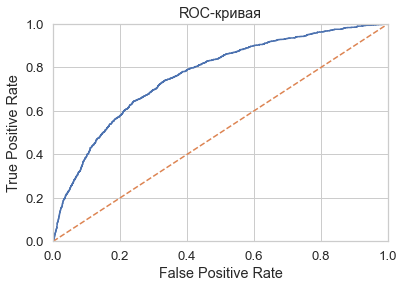

In [43]:
logreg(features_train_ohe, target_train)

* Логистическая регрессия имеет низкие метрики в данной задаче. F1 на уровне 0.5 вряд ли позволит эффективно использовать модель. 80% Accuracy могла бы набрать константная модель за счёт дисбаланса классов, проставляя метрики сильного класса. Отличным результатам по F1 в этой задаче будет Accuracy > 85, F1 > 0.61, ROC-AUC > 0.85. Однако логистическая регрессия имеет неплохой Recall скор, что может быть полезно для данной бизнес задачи.

Для достижения хорошего скора в данной задаче будем использовать несколько алгоритмов градиентного бустинга и классический random forest.

Теперь количество объектов обоих классов в обучающей выборке более сбалансированно. Напишем функцию для подбора гиперпараметров при помощи RandomizedSearchCV:

In [44]:
def RandomSearch(clf, params, features, target):
    model = RandomizedSearchCV(clf, params, scoring='accuracy',n_jobs=-1, cv=3, n_iter=50, random_state=random_state)
    model.fit(features, target)
    print(model.best_estimator_)
    print('Лучшая Accuracy на кросс-валидации:', model.best_score_)
    print('-------------------')

Подберем гиперпараметры при помощи функции для четырых алгоритмов: Random Forest, sklearn GB, LightGBM, XGBoost

Ячейку переведем в формат Raw NBConvert чтобы она не выполнялась заново при перезапуске ноутбука. Лучший скор на кросс-валидации сохраним как константы, а best_estimator моделей в соответсвующих переменных чтобы потом проверить на тесте.

In [45]:
RF_CV_SCORE = 0.856
SGB_CV_SCORE = 0.8632
LGBM_CV_SCORE = 0.834
XGB_CV_SCORE = 0.8605

* На кросс-валидации наибольшую точность (accuracy) показали модели SGB и XGB (86.3% и 86.1% соответственно).

In [46]:
rf_model = RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='log2', min_samples_split=6,
                       n_estimators=400, random_state=random_state)

sklearn_GB_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='log2', min_samples_leaf=3,
                           min_samples_split=20, n_estimators=200,
                           random_state=random_state)

LightGBM_model = lgb.LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=14,
               n_estimators=350, num_leaves=28, random_state=random_state)

XGBoost_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=14,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=random_state,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Обучим Catboost. Ему нужно получить на вход список категориальных признаков, в нашем случае это только география клиента:

In [47]:
categorical_features = ['Geography']

Загрузим модель и передадим ей категориальный признак и основную метрику для оценки:

In [48]:
target_train = target_train.astype('int8')
target_test = target_test.astype('int8')

<a href="https://imgur.com/9vkVsK7"><img src="https://i.imgur.com/9vkVsK7.png" title="source: imgur.com" /></a>

<br> Подобрались следующие гиперпараметры: depth=2, learning_rate=0.2, l2_leaf_reg=5.

* При помощи Catboost удалось получить 87.9% accuracy на кросс-валидации. Это лучший результат среди 5-ти протестированных моделей.

## Тестирование моделей

Далее выберем топ-3 модели по качеству предикта на кросс-валидации и сделаем предикты на тесте с учетом подобранных параметров. В нашем случае это SGB, Catboost и XGboost. Далее попробуем улучшить качество итогового прогноза используя голосование по большинству, чаще всего это помогает улучшить скор.

In [49]:
# Функция для расчета метрик моделей на тестовой выборке
def test_models(predicted):
    print("Accuracy:", accuracy_score(target_test, predicted))
    print("---Другие метрики---")
    print("Roc_auc:", roc_auc_score(target_test, predicted))
    print("Precision:", precision_score(target_test, predicted))
    print("Recall:", recall_score(target_test, predicted))
    print ("F1 мера:", f1_score(target_test, predicted))

<b> SGB test

In [50]:
sklearn_GB_model.fit(features_train_ohe, target_train)
predicted_SGB = sklearn_GB_model.predict(features_test_ohe)

In [51]:
test_models(predicted_SGB)

Accuracy: 0.8668
---Другие метрики---
Roc_auc: 0.7079850486324017
Precision: 0.8235294117647058
Recall: 0.4400785854616896
F1 мера: 0.5736235595390525


* На тестовой выборке accuracy обученного SGB составил 86.68%

<b> Catboost test

In [52]:
model_catboost = CatBoostClassifier(eval_metric='Accuracy', iterations=1000,
                                  cat_features = categorical_features,
                                  depth=4, l2_leaf_reg=3,
                                  learning_rate=0.05,
                                  random_state=random_state,
                                  verbose=100)

model_catboost.fit(features_train, target_train)

0:	learn: 0.8485333	total: 189ms	remaining: 3m 8s
100:	learn: 0.8622667	total: 2.42s	remaining: 21.5s
200:	learn: 0.8680000	total: 4.7s	remaining: 18.7s
300:	learn: 0.8761333	total: 6.98s	remaining: 16.2s
400:	learn: 0.8792000	total: 9.28s	remaining: 13.9s
500:	learn: 0.8828000	total: 11.6s	remaining: 11.6s
600:	learn: 0.8865333	total: 14s	remaining: 9.32s
700:	learn: 0.8898667	total: 16.5s	remaining: 7.03s
800:	learn: 0.8926667	total: 18.9s	remaining: 4.71s
900:	learn: 0.8946667	total: 21.2s	remaining: 2.33s
999:	learn: 0.8974667	total: 23.5s	remaining: 0us


In [53]:
predicted_catboost = model_catboost.predict(features_test)

In [54]:
test_models(predicted_catboost)

Accuracy: 0.8728
---Другие метрики---
Roc_auc: 0.7424619037140611
Precision: 0.7800586510263929
Recall: 0.5225933202357563
F1 мера: 0.6258823529411764


* На тестовой выборке accuracy обученного Catboost составил 87.28%. Кроме того, у Catboost отличная F1 мера с акцентом на Precision.

<b>XGboost test

In [55]:
XGBoost_model.fit(features_train_ohe, target_train)
predicted_XGB = XGBoost_model.predict(features_test_ohe)

[18:07:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
test_models(predicted_XGB)

Accuracy: 0.8616
---Другие метрики---
Roc_auc: 0.7083762984510849
Precision: 0.7762711864406779
Recall: 0.449901768172888
F1 мера: 0.5696517412935322


На тестовой выборке accuracy обученного XGBoost составил 86.16%

### Вывод по тестированию
<br> По результатам кросс-валидации и по результатам работы моделей на тесте лучше других в этой задачи работает обученный Catboost. Ключевая метрика качества (accuracy) превышает 87%, что является отличным результатам для этой задачи. Далее попробуем улучшить качество предикта, используя голосование по большинству среди наших топ-3 моделей.

Визуализируем feature importance лучшей модели:

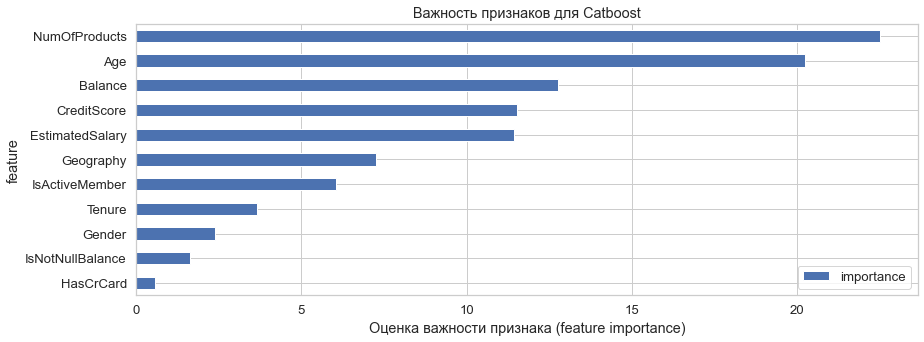

In [57]:
fi_catboost = pd.DataFrame(data ={'feature': features_train.columns, 'importance': model_catboost.feature_importances_})
fi_catboost.sort_values('importance').plot(kind='barh', x = 'feature', figsize=(14, 5))
plt.title('Важность признаков для Catboost')
plt.xlabel('Оценка важности признака (feature importance)')
plt.legend(loc="lower right");

* Наиболее важными признаками оказались количество продуктов и возраст заемщика

### Голосование по большинству

In [58]:
vote = pd.DataFrame([])

vote['predicted_SGB'] = predicted_SGB
vote['predicted_catboost'] = predicted_catboost
vote['predicted_XGB'] = predicted_XGB

vote['sum'] = vote['predicted_SGB'] + vote['predicted_catboost'] + vote['predicted_XGB']

vote['sum_pred'] = vote['sum'] > 1
vote['sum_pred'] = vote['sum_pred'].astype('int8')

In [59]:
test_models(vote[['sum_pred']])

Accuracy: 0.8672
---Другие метрики---
Roc_auc: 0.7162792487608777
Precision: 0.8020477815699659
Recall: 0.46168958742632615
F1 мера: 0.5860349127182045


К сожалению, в данном случае техника не помогла улучшить итоговый скор, все метрики оказались немного ниже, чем у обученного Catboost.

## Модель для бизнеса

Удалось обучить модель, которая имеет высокую точность предсказания (Accuracy более 87%). Однако, для этого бизнеса, на мой взгляд, будет более подходящей модель с высоким Recall score. Если речь идёт об оттоке клиентов из банка, то почти всегда проще и дешевле попытаться сохранить клиента, который с большой вероятностью уйдет в отток. Модель с высоким Recall score могла бы в этом помочь.

<br> Чтобы добиться высокого Recall score с помощью Catboost необходимо помимо смены eval metric установить балансировку классов (также Catboost позволяет вручную изменить веса в задаваемых пропорциях). Но нужно понимать, что такое изменение параметров уронит другие метрики и эта модель не будет самой оптимальной, но она будет решать конкретную бизнес задачу - находить клиентов, которым стоит направить специальное предложение или приложить другия усилия для их сохранения.

In [60]:
model_catboost_recall = CatBoostClassifier(eval_metric='Recall', iterations=1000,
                                    cat_features = categorical_features,
                                    random_state=random_state,
                                    auto_class_weights = 'Balanced',
                                    verbose=200)

model_catboost_recall.fit(features_train, target_train)

predicted_catboost_recall = model_catboost_recall.predict(features_test)

Learning rate set to 0.024355
0:	learn: 0.7290576	total: 22.8ms	remaining: 22.7s
200:	learn: 0.7801047	total: 5.47s	remaining: 21.8s
400:	learn: 0.8017016	total: 10.6s	remaining: 15.9s
600:	learn: 0.8304974	total: 15.9s	remaining: 10.5s
800:	learn: 0.8566754	total: 21.3s	remaining: 5.29s
999:	learn: 0.8802356	total: 27s	remaining: 0us


In [61]:
test_models(predicted_catboost_recall)

Accuracy: 0.8184
---Другие метрики---
Roc_auc: 0.7843517834183097
Precision: 0.5401459854014599
Recall: 0.7269155206286837
F1 мера: 0.6197654941373535


In [62]:
pd.Series(predicted_catboost_recall).mean()

0.274

* Recall обученной модели составил 72.7%. Как и ожидалось, другие метрики ниже. Тем не менее, при дисбалансе классов 80/20 модель определит как склонных к уходу ~27.4% клиентов и в 72.7% случаев это будет правильный выбор.

Визуализируем оценку важности признаков для данной модели:

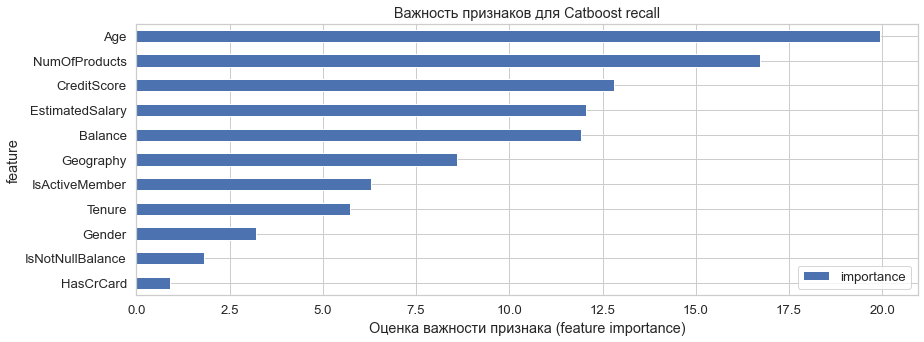

In [63]:
fi_catboost_recall = pd.DataFrame(data ={'feature': features_train.columns,\
                                         'importance': model_catboost_recall.feature_importances_})

fi_catboost_recall.sort_values('importance').plot(kind='barh', x = 'feature', figsize=(14, 5))
plt.title('Важность признаков для Catboost recall')
plt.xlabel('Оценка важности признака (feature importance)')
plt.legend(loc="lower right");

* Для данной модели самым важным признаком оказался возраст заемщика, а на втором месте количество продуктов (поменялись местами).

## Итог

В работе был проанализирован датасет с данными о клиентах банка и созданы модели чтобы предсказывать уход в отток. Первая модель имеет очень высокую точность прогноза (accuracy) - 87.3%, а также отличную F1 меру - 62.6% (при высокой precision и низкой recall).

Вторая модель не имеет топовых показателей, однако её применение может принести больше пользы бизнесу. Так, среди ~20% клиентов, которые попадут в отток, она может обнаружить ~72.7% из них. У неё будет больше ложных срабатываний - при 20% клиентов, которые уйдут, модель "подсветит" 27.4%, однако проработка этих клиентов поможет уменьшить отток в целом. F1 данной модели тоже находится на достойном уровне (почти 62%), accuracy немного завален (81.8%) из-за дисбаланса классов. Применение модели оправдано, если стоимость сохранения старого клиента ниже, чем стоимость привлечения нового.